## Exploring Survival On The Titanic (Python)
#### Converting into python, from r, some of the ideas from Megan Risdals brilliant analysis - https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/comments to see if I can improve my score.

- Feature Engineering
- Missing Value Imputation
- Prediction

In [112]:
# Import libraries

import numpy as np
from numpy.random import random_integers
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

print('Libraries Ready!')

Libraries Ready!


In [113]:
# Load training and test data
train = pd.read_csv('/home/sophie/projects/Titanic/data/train.csv', header=0)
test = pd.read_csv('/home/sophie/projects/Titanic/data/test.csv', header=0)

# bind training & test data so we can apply all the following changes to both in one go.
full = pd.concat([train,test])

In [114]:
print(len(full))
print(len(train)+len(test))
print(full.shape)
print(full.head())
print(list(full))
print(list(train))
print(list(test))

1309
1309
(1309, 12)
    Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  
0       3    male      1       0.0         A/5 21171  
1       1  female      1       1.0          PC 17599  
2       3  female      0       1.0  STON/O2. 3101282  
3       1  female      1       1.0            113803  
4       3    male      0       0.0  

In [115]:
# rows, columns with iloc
print(train.PassengerId.iloc[-1])

# This will be where we want to split it in the end.

891


### Feature Engineering

In [116]:
# Grab title from passenger names

full['Title'] = full['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

#first convert the Title column into a set.
title = set(full['Title'] )
print(title)

{'Rev', 'Miss', 'Mme', 'Jonkheer', 'Col', 'Dr', 'Sir', 'Lady', 'Don', 'Major', 'the Countess', 'Master', 'Dona', 'Ms', 'Capt', 'Mlle', 'Mrs', 'Mr'}


In [117]:
# Count the number of times each one appears
count_title = Counter(full['Title'])

print(count_title)

Counter({'Mr': 757, 'Miss': 260, 'Mrs': 197, 'Master': 61, 'Rev': 8, 'Dr': 8, 'Col': 4, 'Major': 2, 'Mlle': 2, 'Ms': 2, 'Sir': 1, 'Mme': 1, 'Lady': 1, 'Don': 1, 'the Countess': 1, 'Dona': 1, 'Capt': 1, 'Jonkheer': 1})


In [118]:
# get male/female counts using groupby
group = full.groupby(['Title', 'Sex']).size()
print (group)

Title         Sex   
Capt          male        1
Col           male        4
Don           male        1
Dona          female      1
Dr            female      1
              male        7
Jonkheer      male        1
Lady          female      1
Major         male        2
Master        male       61
Miss          female    260
Mlle          female      2
Mme           female      1
Mr            male      757
Mrs           female    197
Ms            female      2
Rev           male        8
Sir           male        1
the Countess  female      1
dtype: int64


In [119]:
p = group.reset_index()
p.index = p['Title']+p['Sex']

#Drop columns
p = p.drop(['Title','Sex'], axis=1)

print (p)

                      0
Captmale              1
Colmale               4
Donmale               1
Donafemale            1
Drfemale              1
Drmale                7
Jonkheermale          1
Ladyfemale            1
Majormale             2
Mastermale           61
Missfemale          260
Mllefemale            2
Mmefemale             1
Mrmale              757
Mrsfemale           197
Msfemale              2
Revmale               8
Sirmale               1
the Countessfemale    1


In [120]:
print(p[(p <= 2)])
# [Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

                      0
Captmale            1.0
Colmale             NaN
Donmale             1.0
Donafemale          1.0
Drfemale            1.0
Drmale              NaN
Jonkheermale        1.0
Ladyfemale          1.0
Majormale           2.0
Mastermale          NaN
Missfemale          NaN
Mllefemale          2.0
Mmefemale           1.0
Mrmale              NaN
Mrsfemale           NaN
Msfemale            2.0
Revmale             NaN
Sirmale             1.0
the Countessfemale  1.0


Any values below 2 will be converted to "Rare" and Mlle, Mme and Ms will be converted to Miss.

In [121]:
# Titles with very low cell counts to be combined to "rare" level

full['Title'].replace(to_replace = ['Mlle','Ms'], value = 'Miss', inplace=True)

full['Title'].replace(to_replace = ['Mme'], value = 'Mrs', inplace=True)

full['Title'].replace(to_replace = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr'
                                    , 'Major', 'Rev', 'Sir', 'Jonkheer'], value = 'Rare', inplace=True)
# Show title counts by sex again

print(full.head())

# get counts using groupby
group = full.groupby(['Title', 'Sex']).size()

print(group)

    Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket Title  
0       3    male      1       0.0         A/5 21171    Mr  
1       1  female      1       1.0          PC 17599   Mrs  
2       3  female      0       1.0  STON/O2. 3101282  Miss  
3       1  female      1       1.0            113803   Mrs  
4       3    male      0   

In [122]:
# get counts using groupby
group = full.groupby(['Title', 'Sex']).size()

print(group)

Title   Sex   
Master  male       61
Miss    female    264
Mr      male      757
Mrs     female    198
Rare    female      4
        male       25
dtype: int64


My counts for each title now match up with Megans.

In [123]:
# Finally, grab surname from passenger name and make a new column
# Take the first word on the left side of the ,
full['Surname'] = full['Name'].apply(lambda x: x.split(',')[0].strip())
print(full['Surname'][0:3])
print(list(full))

0       Braund
1      Cumings
2    Heikkinen
Name: Surname, dtype: object
['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'Surname']


### Families

In [124]:
# Create a family size variable including the passenger themselves
full['FamSize'] = full['SibSp'] + full['Parch'] + 1

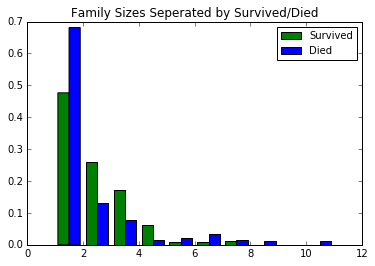

In [125]:
# Visualize the relationship between family size & survival

# The total number of bins should be the maximum family size
n_bins = max(full['FamSize'])

# In the end we just put the data into normal arrays which will exclude nans. axes.hist can't take nans
x = full['FamSize'][full['Survived'] == 1]
y = full['FamSize'][full['Survived'] == 0]

fig, ax = plt.subplots()

labels = ['Survived','Died']
colors = ['green', 'blue']

ax.hist([x,y], normed=1, histtype='bar', color=colors, label=labels )
ax.legend(prop={'size': 10})
ax.set_title('Family Sizes Seperated by Survived/Died')

You had best chances of survival if you were in a family sized 2 - 4 people. Anything smaller or larger decreases your chances.

Next we will change this information into the categories single, small, large for types of family.

In [126]:
# Discretize family size. We will use this later when we predict missing values of age.

def famsize_d(x):
    if x == 1:
        return 'Single'
    elif (x >=2) & (x <= 4):
        return 'Small Family'
    else: return 'Large Family'
    
full['FamSize_D'] = full['FamSize'].map(famsize_d)
print(max(full['FamSize_D']))

Small Family


In [127]:
# Also make a column with Survived/Died in words so that mosaic can put these into the plot
#df['Gender'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)
full['Survive_txt'] = full['Survived'].map({1:'Survived', 0:'Died'})

(<matplotlib.figure.Figure at 0x7fcdf8671f60>,
 OrderedDict([(('Small Family', 'Died'),
               (0.0, 0.0, 0.3244768921336578, 0.41983343193919809)),
              (('Small Family', 'Survived'),
               (0.0,
                0.42315569107541073,
                0.3244768921336578,
                0.57684430892458916)),
              (('Single', 'Died'),
               (0.3294273871831628,
                0.0,
                0.5967263393005967,
                0.6941479982924702)),
              (('Single', 'Survived'),
               (0.3294273871831628,
                0.69747025742868274,
                0.5967263393005967,
                0.30252974257131715)),
              (('Large Family', 'Died'),
               (0.9311042215332644,
                0.0,
                0.06889577846673557,
                0.83592326653091842)),
              (('Large Family', 'Survived'),
               (0.9311042215332644,
                0.83924552566713095,
                0.06

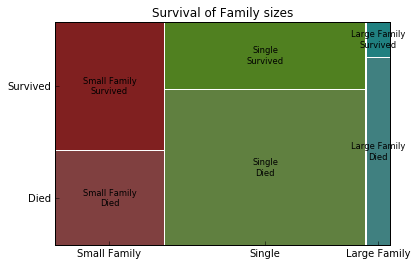

In [128]:
# Show family size by survival using a mosaic plot (maybe not)
from statsmodels.graphics.mosaicplot import mosaic

mosaic(full, ['FamSize_D', 'Survive_txt'], title = 'Survival of Family sizes')

Similar to the histogram we see that being in a small family was preferable to either being single or in a large family. 

There’s probably some potentially useful information in the passenger cabin variable including about their deck. Let’s take a look.

In [148]:
print(list(full))

['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'Surname', 'FamSize', 'FamSize_D', 'Survive_txt', 'Deck']
      Age        Cabin Embarked      Fare  \
0    22.0          NaN        S    7.2500   
1    38.0          C85        C   71.2833   
2    26.0          NaN        S    7.9250   
3    35.0         C123        S   53.1000   
4    35.0          NaN        S    8.0500   
5     NaN          NaN        Q    8.4583   
6    54.0          E46        S   51.8625   
7     2.0          NaN        S   21.0750   
8    27.0          NaN        S   11.1333   
9    14.0          NaN        C   30.0708   
10    4.0           G6        S   16.7000   
11   58.0         C103        S   26.5500   
12   20.0          NaN        S    8.0500   
13   39.0          NaN        S   31.2750   
14   14.0          NaN        S    7.8542   
15   55.0          NaN        S   16.0000   
16    2.0          NaN        Q   29.1250   
17    

In [130]:
# Look at the cabin variable. Cabin is missing a lot of values.
print(full.count())
print(full['Cabin'].dropna()[0:30])


Age            1046
Cabin           295
Embarked       1307
Fare           1308
Name           1309
Parch          1309
PassengerId    1309
Pclass         1309
Sex            1309
SibSp          1309
Survived        891
Ticket         1309
Title          1309
Surname        1309
FamSize        1309
FamSize_D      1309
Survive_txt     891
dtype: int64
1              C85
3             C123
6              E46
10              G6
11            C103
21             D56
23              A6
27     C23 C25 C27
31             B78
52             D33
54             B30
55             C52
61             B28
62             C83
66             F33
75           F G73
88     C23 C25 C27
92             E31
96              A5
97         D10 D12
102            D26
110           C110
118        B58 B60
123           E101
124            D26
128          F E69
136            D47
137           C123
139            B86
148             F2
Name: Cabin, dtype: object


In [131]:
# One way to select part of a string, use str[0]
print(full['Cabin'].dropna().str[0][0:1])

1    C
Name: Cabin, dtype: object


In [132]:
# Make a new "deck" variable with just the deck letter
# If there are multiple cabins in the value, this just stores the first letter.
full['Deck'] = full['Cabin'].str.extract('(?P<letter>[ABCDEF])')

print(full['Deck'].dropna()[0:10])

1     C
3     C
6     E
11    C
21    D
23    A
27    C
31    B
52    D
54    B
Name: Deck, dtype: object


/home/sophie/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()


### Missingness

In [133]:
# Passengers 62 and 830 are missing Embarkment. 
full[full['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,FamSize,FamSize_D,Survive_txt,Deck
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,Icard,1,Single,Survived,B
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,Stone,1,Single,Survived,B


We will infer their values for embarkment based on present data that we can imagine may be 
relevant: passenger class and fare. Would people of certain status get on at different ports?

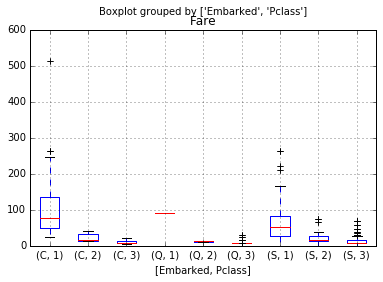

In [134]:
# Use ggplot2 to visualize embarkment, passenger class, & median fare
#bp = df.boxplot(column=['Col1','Col2'], by=['X','Y'])

bp = full.boxplot(column=['Fare'], by = ['Embarked','Pclass'])

Voilà! The median fare for a first class passenger departing from Charbourg (‘C’) coincides nicely with the $80 paid by our embarkment-deficient passengers. I think we can safely replace the NA values with ‘C’.

In [135]:
# Fill in passengers 62 and 830 with 'C'
full['Embarked'][full['Embarked'].isnull()] = 'C'
print(full['Embarked'][full['PassengerId'] == 62])

61    C
Name: Embarked, dtype: object


/home/sophie/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [136]:
# check there are no more null values
full[full['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,FamSize,FamSize_D,Survive_txt,Deck


We’re close to fixing the handful of NA values here and there. Passenger on row 1044 has an NA Fare value

In [137]:
# Show row 1044
print(full[full['Fare'].isnull()])

# Find the median fare for class/embarkment
group = full.groupby(['Embarked','Pclass']).median()

print(group['Fare']) # What is the value for S/3? $8.1

      Age Cabin Embarked  Fare                Name  Parch  PassengerId  \
152  60.5   NaN        S   NaN  Storey, Mr. Thomas      0         1044   

     Pclass   Sex  SibSp  Survived Ticket Title Surname  FamSize FamSize_D  \
152       3  male      0       NaN   3701    Mr  Storey        1    Single   

    Survive_txt Deck  
152         NaN  NaN  
Embarked  Pclass
C         1         78.2667
          2         15.3146
          3          7.8958
Q         1         90.0000
          2         12.3500
          3          7.7500
S         1         52.0000
          2         15.3750
          3          8.0500
Name: Fare, dtype: float64


In [111]:
# Replace missing fare value with median fare for class/embarkment ($8.1)
full['Fare'][full['Fare'].isnull()] = 8

print(full[full['PassengerId'] == 1044])

      Age Cabin Embarked  Fare                Name  Parch  PassengerId  \
152  60.5   NaN        S   8.0  Storey, Mr. Thomas      0         1044   

     Pclass   Sex  SibSp  Survived Ticket Title Surname  FamSize FamSize_D  \
152       3  male      0       NaN   3701    Mr  Storey        1    Single   

    Survive_txt Deck  
152         NaN  NaN  


/home/sophie/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Save the data as it is now, so we can start a new script with it treated as it is now. 

In [149]:
path = '/home/sophie/Python/notechain/Titanic/data'

full.to_csv('%s/058_full.csv'%path, index=False)

### Predictive Imputation

We will create a model predicting ages based on other variables.

In [140]:
# Show number of missing Age values
len(full[full['Age'].isnull()])


263

We could definitely use rpart (recursive partitioning for regression) to predict missing ages, but I’m going to use the mice package for this task just for something different. You can read more about multiple imputation using chained equations in r here (PDF). Since we haven’t done it yet, I’ll first factorize the factor variables and then perform mice imputation.

In [ ]:
from fancyimpute import mice

# get the columns in the right format. Megan uses 'PassengerId','Pclass','Sex','Embarked','Title',
# 'Surname','Family','FsizeD')


# apply mice
full['AgeFill'] = Mice().complete()


In [ ]:
# Perform mice imputation, excluding certain less-than-useful variables:

In [ ]:
# compare the imputation distribution with the original data distribtion
# Plot Age

# Replace Age variable from the mice model.

# Show new number of missing Age values

### Feature Engineering round 2

Now that we know everyone’s age, we can create a couple of new age-dependent variables: Child and Mother. A child will simply be someone under 18 years of age and a mother is a passenger who is 1) female, 2) is over 18, 3) has more than 0 children (no kidding!), and 4) does not have the title ‘Miss

In [12]:
# First we'll look at the relationship between age & survival
# For both male and female


In [13]:
# Create the column child, and indicate whether child or adult

# Show counts

In [14]:
# Adding Mother variable

All of the variables we care about should be taken care of and there should be no missing data. I’m going to double check just to be sure:

### Prediction

Our first step is to split the data back into the original test and training sets.

In [15]:
# check data

In [16]:
# Build a model using RandomForest

# Show model error

### Variable Importance

Let’s look at relative variable importance by plotting the mean decrease in Gini calculated across all trees.

In [17]:
# Get importance

# Create a rank variable based on importance

# Use ggplot2 to visualize the relative importance of variables

In [ ]:
# Predict using the test set

# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)

